# Ball & Centerline Detection Demo
Use this notebook to play with the parameters that detect the orange ball and estimate the track centerline for `track.png`. Everything is pure OpenCV + NumPy so it should run in any Jupyter environment with those libraries installed.

In [ ]:
import cv2, numpy as np, matplotlib.pyplot as plt, os

IMG_PATHS = [
    'track.png',
    'off_track.png',
    'out.png']

for img_path in IMG_PATHS:
    assert os.path.exists(img_path), f'Image not found: {img_path}'
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 4))
    plt.imshow(img_rgb)
    plt.title(f'Original frame for {img_path}')
    plt.axis('off')


## 1 . Ball‑detection parameters

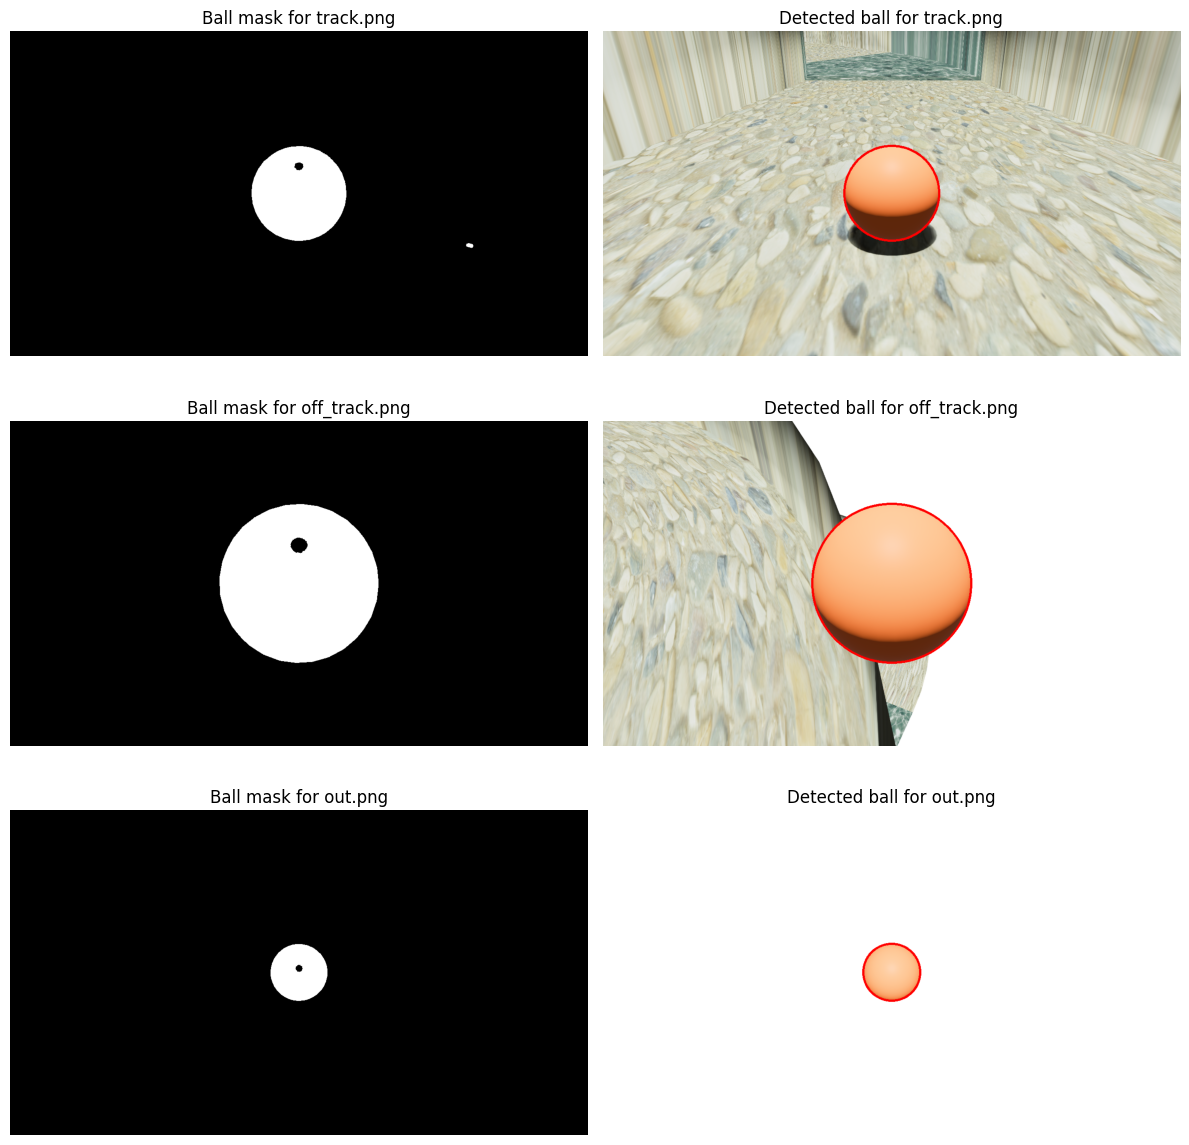

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def detect_ball(img_path, ball_hsv_low, ball_hsv_high, kernel_size):
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, ball_hsv_low, ball_hsv_high)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    overlay = img_rgb.copy()
    if contours:
        largest = max(contours, key=cv2.contourArea)
        (cx, cy), r = cv2.minEnclosingCircle(largest)
        cx, cy, r = int(cx), int(cy), int(r)
        cv2.circle(overlay, (cx, cy), r, (255, 0, 0), 3)

    return mask_clean, overlay


# --- tweak these ---
ball_hsv_low = np.array([5, 80, 80])  # lower HSV bound for the orange hue
ball_hsv_high = np.array([25, 255, 255])  # upper HSV bound
kernel_size = 9  # morphological opening kernel size (odd)

# Plot results for all images
fig, axes = plt.subplots(len(IMG_PATHS), 2, figsize=(12, 4 * len(IMG_PATHS)))
for i, img_path in enumerate(IMG_PATHS):
    mask_clean, overlay = detect_ball(img_path, ball_hsv_low, ball_hsv_high, kernel_size)
    axes[i, 0].imshow(mask_clean, cmap='gray')
    axes[i, 0].set_title(f'Ball mask for {img_path}')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(overlay)
    axes[i, 1].set_title(f'Detected ball for {img_path}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

## 2 . Track‑center estimation
This step sums Canny edges per column and picks the two highest peaks that are far apart (≈ left & right wall). The magenta line is the inferred center.

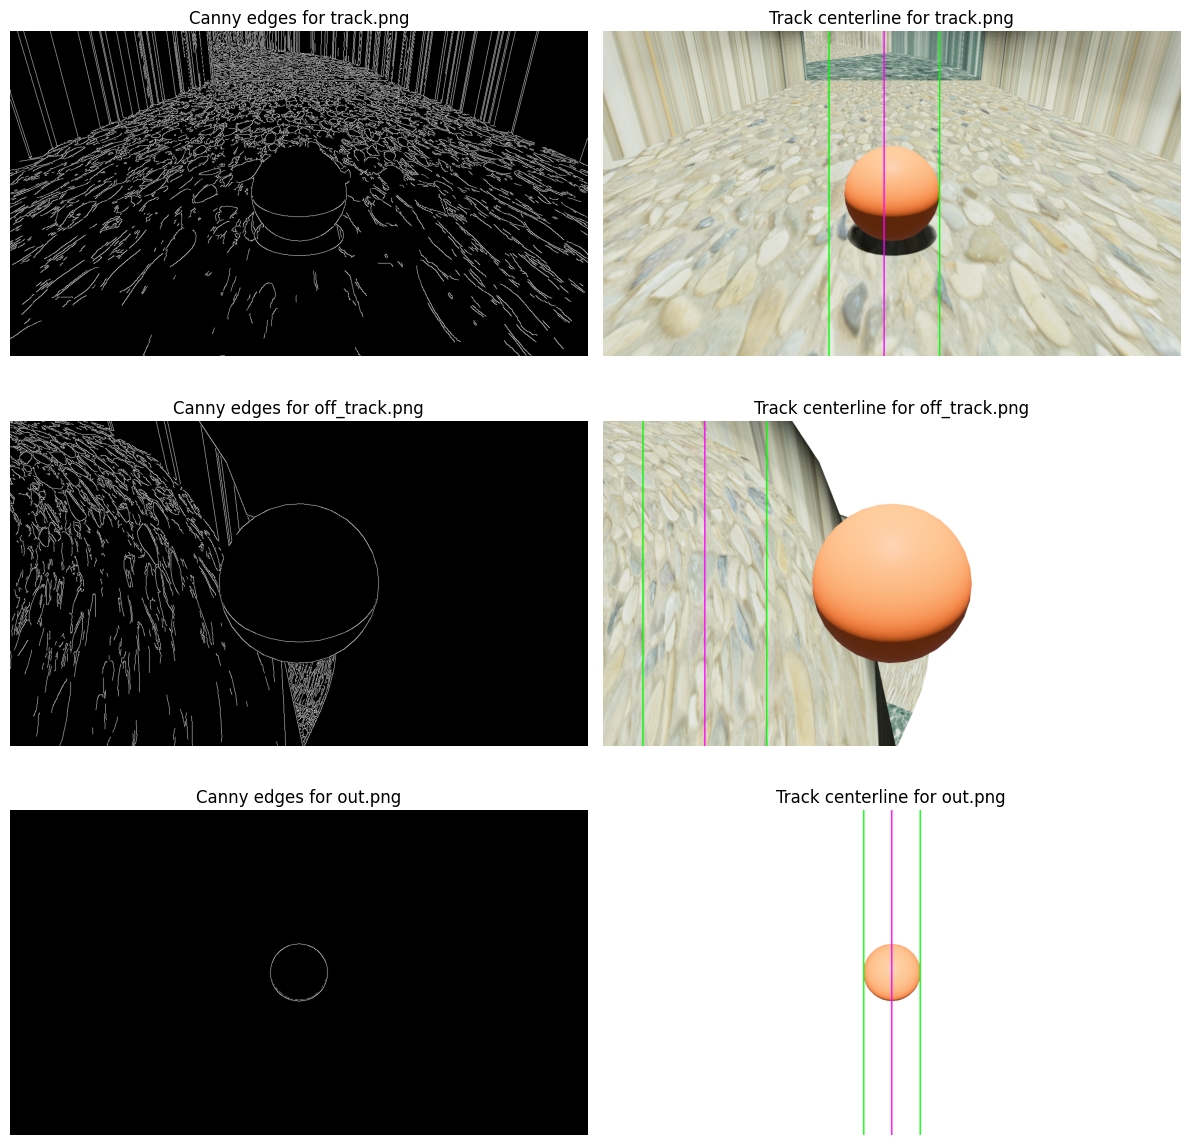

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def estimate_track_center(img_path, min_peak_distance=100, canny_threshold1=50, canny_threshold2=100):
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, canny_threshold1, canny_threshold2)
    col_sum = edges.sum(axis=0)

    # Find the two tallest peaks that are at least `min_peak_distance` apart
    peaks = np.argsort(col_sum)[::-1]  # descending order
    x1 = peaks[0]
    x2 = next(idx for idx in peaks if abs(idx - x1) > min_peak_distance)

    overlay = img_rgb.copy()
    h = overlay.shape[0]
    cv2.line(overlay, (x1, 0), (x1, h), (0, 255, 0), 2)  # left wall
    cv2.line(overlay, (x2, 0), (x2, h), (0, 255, 0), 2)  # right wall
    cx_track = (x1 + x2) // 2
    cv2.line(overlay, (cx_track, 0), (cx_track, h), (255, 0, 255), 2)  # centerline

    return edges, overlay


# Plot results for all images
fig, axes = plt.subplots(len(IMG_PATHS), 2, figsize=(12, 4 * len(IMG_PATHS)))
for i, img_path in enumerate(IMG_PATHS):
    edges, overlay = estimate_track_center(img_path)
    axes[i, 0].imshow(edges, cmap='gray')
    axes[i, 0].set_title(f'Canny edges for {img_path}')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(overlay)
    axes[i, 1].set_title(f'Track centerline for {img_path}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

3. Estimate Ball position above track

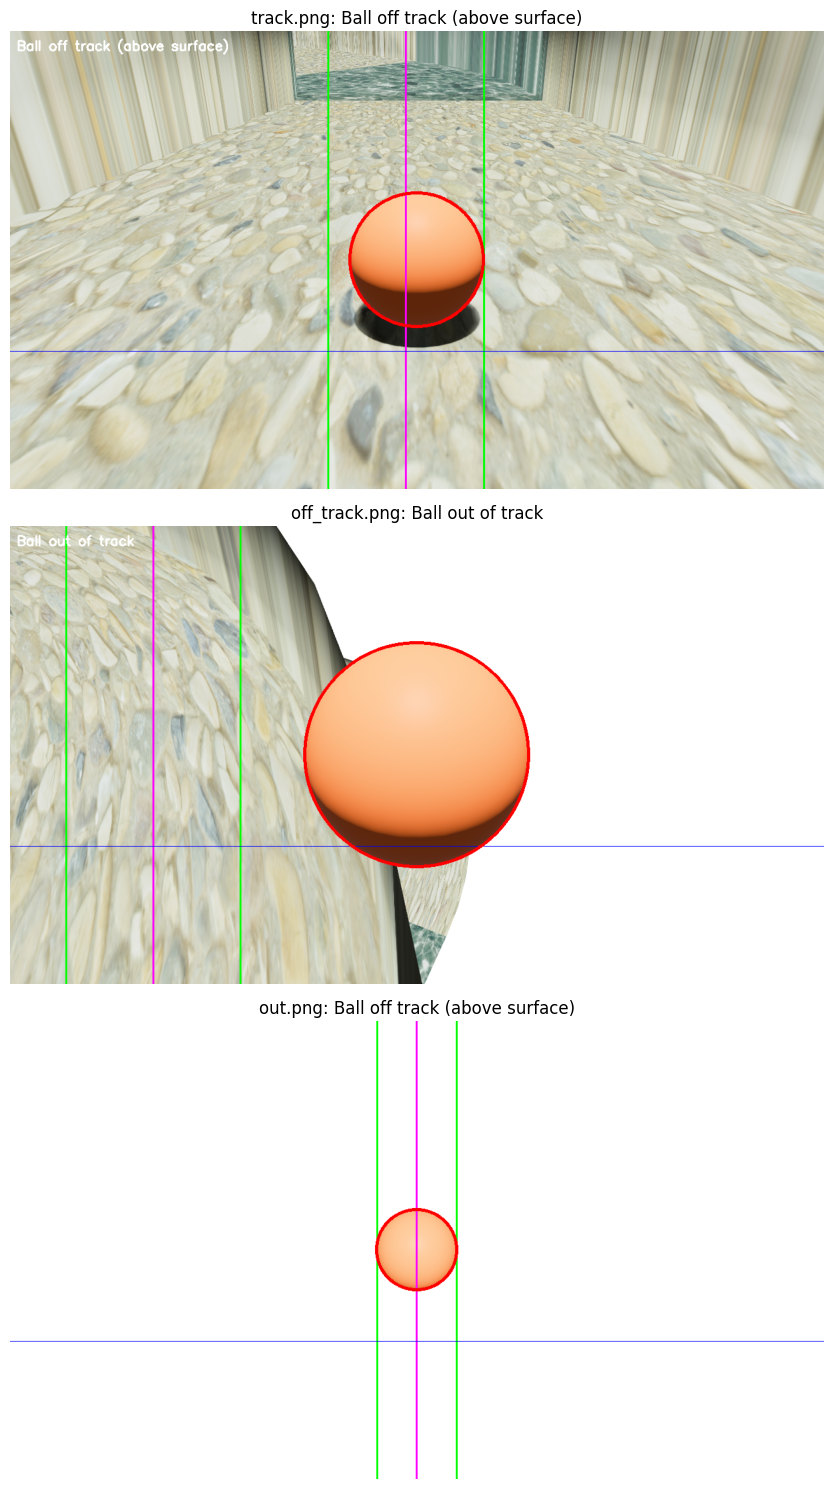

[{'ball_status': 'off_track',
  'ball_found': True,
  'ball_position': (639, 359, 105),
  'track_walls': (np.int64(500), np.int64(745)),
  'track_center': np.int64(622),
  'status': 'Ball off track (above surface)',
  'visualization': array([[[212, 215, 204],
          [212, 215, 206],
          [212, 215, 206],
          ...,
          [175, 179, 163],
          [177, 180, 165],
          [178, 181, 168]],
  
         [[211, 215, 204],
          [212, 215, 205],
          [212, 216, 206],
          ...,
          [176, 179, 164],
          [178, 180, 166],
          [178, 181, 168]],
  
         [[211, 215, 204],
          [211, 215, 205],
          [212, 215, 205],
          ...,
          [177, 180, 164],
          [177, 180, 167],
          [179, 181, 168]],
  
         ...,
  
         [[221, 217, 195],
          [221, 217, 195],
          [221, 217, 196],
          ...,
          [196, 205, 198],
          [202, 209, 202],
          [206, 212, 206]],
  
         [[220, 217, 195],

In [20]:
def estimate_ball_above_track_height(img_path,
                                     ball_hsv_low=np.array([5, 80, 80]),
                                     ball_hsv_high=np.array([25, 255, 255]),
                                     kernel_size=9,
                                     min_peak_distance=100,
                                     canny_threshold1=50,
                                     canny_threshold2=100,
                                     track_surface_height_ratio=0.7):  # Track height threshold

    # Load the image
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w = img_bgr.shape[:2]

    # Detect the ball
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, ball_hsv_low, ball_hsv_high)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    ball_found = False
    cx_ball, cy_ball, r_ball = 0, 0, 0

    if contours:
        ball_found = True
        largest = max(contours, key=cv2.contourArea)
        (cx_ball, cy_ball), r_ball = cv2.minEnclosingCircle(largest)
        cx_ball, cy_ball, r_ball = int(cx_ball), int(cy_ball), int(r_ball)

    # Estimate track walls
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, canny_threshold1, canny_threshold2)
    col_sum = edges.sum(axis=0)

    # Find the two tallest peaks that are at least min_peak_distance apart
    peaks = np.argsort(col_sum)[::-1]
    x1 = peaks[0]
    x2 = next(idx for idx in peaks if abs(idx - x1) > min_peak_distance)

    # Ensure x1 is the left wall
    if x1 > x2:
        x1, x2 = x2, x1

    cx_track = (x1 + x2) // 2

    # Define track surface height
    track_surface_y = int(h * track_surface_height_ratio)

    # Create visualization
    overlay = img_rgb.copy()

    # Draw track boundaries
    cv2.line(overlay, (x1, 0), (x1, h), (0, 255, 0), 2)  # left wall
    cv2.line(overlay, (x2, 0), (x2, h), (0, 255, 0), 2)  # right wall
    cv2.line(overlay, (cx_track, 0), (cx_track, h), (255, 0, 255), 2)  # centerline
    cv2.line(overlay, (0, track_surface_y), (w, track_surface_y), (0, 0, 255), 1)  # height threshold

    # Classification logic
    status = "Ball not found"
    ball_status = "unknown"

    if ball_found:
        cv2.circle(overlay, (cx_ball, cy_ball), r_ball, (255, 0, 0), 3)

        # Check if ball is between track walls
        within_walls = (x1 <= cx_ball <= x2)

        # Check if ball is on the track surface (bottom of ball touches or is below threshold)
        ball_bottom = cy_ball + r_ball
        on_track_surface = ball_bottom >= track_surface_y

        if not within_walls:
            status = "Ball out of track"
            ball_status = "out"
        elif not on_track_surface:
            status = "Ball off track (above surface)"
            ball_status = "off_track"
        else:
            status = "Ball on track"
            ball_status = "on_track"

        # Add status text to visualization
        cv2.putText(overlay, status, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    return {
        'ball_status': ball_status,
        'ball_found': ball_found,
        'ball_position': (cx_ball, cy_ball, r_ball) if ball_found else None,
        'track_walls': (x1, x2),
        'track_center': cx_track,
        'status': status,
        'visualization': overlay
    }


# Function to analyze all images
def analyze_all_ball_positions(img_paths, **kwargs):
    fig, axes = plt.subplots(len(img_paths), 1, figsize=(12, 5 * len(img_paths)))
    if len(img_paths) == 1:
        axes = [axes]

    results = []
    for i, img_path in enumerate(img_paths):
        result = estimate_ball_above_track_height(img_path, **kwargs)
        axes[i].imshow(result['visualization'])
        axes[i].set_title(f"{img_path}: {result['status']}")
        axes[i].axis('off')
        results.append(result)

    plt.tight_layout()
    plt.show()
    return results


analyze_all_ball_positions(IMG_PATHS)

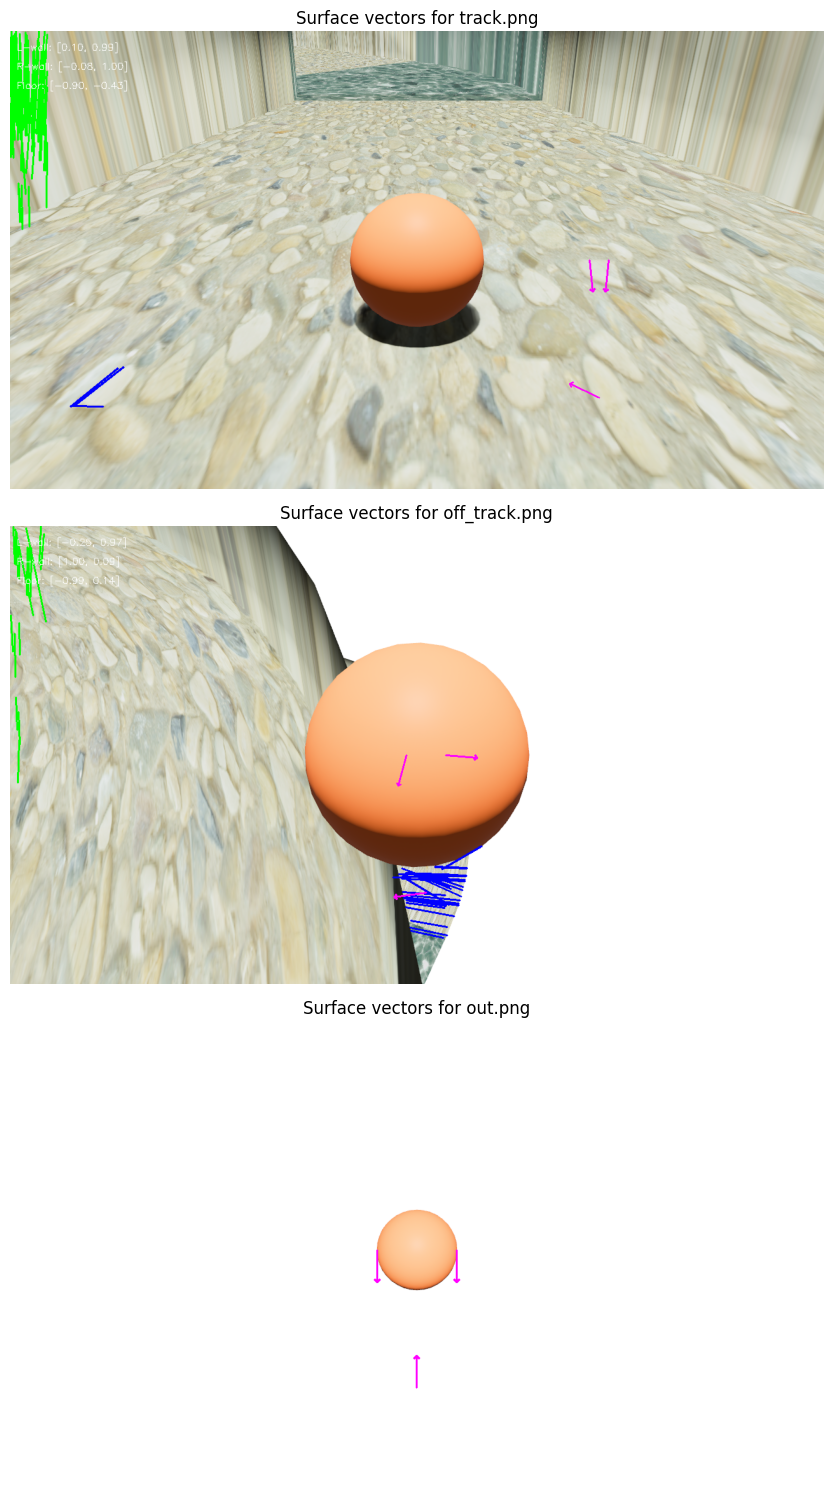

[{'left_wall_vector': array([0.10166885, 0.9948183 ]),
  'right_wall_vector': array([-0.08425722,  0.99644404]),
  'floor_vector': array([-0.90357681, -0.42842613]),
  'visualization': array([[[212, 215, 204],
          [  0, 255,   0],
          [  0, 255,   0],
          ...,
          [175, 179, 163],
          [177, 180, 165],
          [178, 181, 168]],
  
         [[211, 215, 204],
          [  0, 255,   0],
          [  0, 255,   0],
          ...,
          [176, 179, 164],
          [178, 180, 166],
          [178, 181, 168]],
  
         [[211, 215, 204],
          [  0, 255,   0],
          [  0, 255,   0],
          ...,
          [177, 180, 164],
          [177, 180, 167],
          [179, 181, 168]],
  
         ...,
  
         [[221, 217, 195],
          [221, 217, 195],
          [221, 217, 196],
          ...,
          [196, 205, 198],
          [202, 209, 202],
          [206, 212, 206]],
  
         [[220, 217, 195],
          [221, 217, 196],
          [220, 217, 1

In [21]:
def estimate_track_surfaces(img_path,
                           min_peak_distance=100,
                           canny_threshold1=50,
                           canny_threshold2=100,
                           hough_threshold=50,
                           min_line_length=50,
                           max_line_gap=10):
    """
    Estimates the surface vectors of track floor, left wall, and right wall.
    """
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    h, w = img_bgr.shape[:2]

    # Edge detection
    edges = cv2.Canny(gray, canny_threshold1, canny_threshold2)

    # Find track walls using column sums (same as before)
    col_sum = edges.sum(axis=0)
    peaks = np.argsort(col_sum)[::-1]
    x1 = peaks[0]
    x2 = next(idx for idx in peaks if abs(idx - x1) > min_peak_distance)

    # Ensure x1 is the left wall
    if x1 > x2:
        x1, x2 = x2, x1

    # Extract regions of interest for more precise wall detection
    left_roi = edges[:, max(0, x1-20):min(w, x1+20)]
    right_roi = edges[:, max(0, x2-20):min(w, x2+20)]

    # Use Hough Line Transform to detect wall orientation
    overlay = img_rgb.copy()

    # Find lines in the left and right regions
    left_lines = cv2.HoughLinesP(left_roi, 1, np.pi/180, hough_threshold,
                                minLineLength=min_line_length, maxLineGap=max_line_gap)

    right_lines = cv2.HoughLinesP(right_roi, 1, np.pi/180, hough_threshold,
                                 minLineLength=min_line_length, maxLineGap=max_line_gap)

    # For floor detection, focus on lower part of image
    floor_roi_y = int(h * 0.7)  # Starting from 70% down the image
    floor_roi = edges[floor_roi_y:, :]
    floor_lines = cv2.HoughLinesP(floor_roi, 1, np.pi/180, hough_threshold//2,
                                 minLineLength=min_line_length, maxLineGap=max_line_gap)

    # Initialize vectors
    left_wall_vector = np.array([0, 1])  # Default: vertical down
    right_wall_vector = np.array([0, 1])  # Default: vertical down
    floor_vector = np.array([0, -1])      # Default: vertical up (normal to floor)

    # Process left wall lines
    if left_lines is not None and len(left_lines) > 0:
        # Group lines by angle and find dominant orientation
        left_angles = []
        for line in left_lines:
            x1, y1, x2, y2 = line[0]
            if abs(x2 - x1) > 0:  # Avoid division by zero
                angle = np.arctan2(y2 - y1, x2 - x1)
                left_angles.append(angle)
                # Draw the line on the left wall region
                cv2.line(overlay, (max(0, x1-20) + x1, y1), (max(0, x1-20) + x2, y2), (0, 255, 0), 2)

        if left_angles:
            # Find most common angle
            mean_angle = np.mean(left_angles)
            left_wall_vector = np.array([np.sin(mean_angle), np.cos(mean_angle)])

    # Process right wall lines
    if right_lines is not None and len(right_lines) > 0:
        right_angles = []
        for line in right_lines:
            x1, y1, x2, y2 = line[0]
            if abs(x2 - x1) > 0:
                angle = np.arctan2(y2 - y1, x2 - x1)
                right_angles.append(angle)
                # Draw the line on the right wall region
                cv2.line(overlay, (max(0, x2-20) + x1, y1), (max(0, x2-20) + x2, y2), (0, 255, 0), 2)

        if right_angles:
            mean_angle = np.mean(right_angles)
            right_wall_vector = np.array([np.sin(mean_angle), np.cos(mean_angle)])

    # Process floor lines
    if floor_lines is not None and len(floor_lines) > 0:
        floor_angles = []
        for line in floor_lines:
            x1, y1, x2, y2 = line[0]
            if abs(y2 - y1) > 0:  # Horizontal lines have small y2-y1
                angle = np.arctan2(y2 - y1, x2 - x1)
                if abs(angle) < np.pi/4:  # Only consider mostly horizontal lines
                    floor_angles.append(angle)
                    # Draw the line on the floor region
                    cv2.line(overlay, (x1, floor_roi_y + y1), (x2, floor_roi_y + y2), (0, 0, 255), 2)

        if floor_angles:
            mean_angle = np.mean(floor_angles)
            # The floor vector is perpendicular to the floor line direction
            floor_vector = np.array([-np.sin(mean_angle+np.pi/2), -np.cos(mean_angle+np.pi/2)])

    # Draw vectors on image (scaled for visibility)
    vector_scale = 50
    center_x = (x1 + x2) // 2
    center_y = h // 2
    floor_y = int(h * 0.8)

    # Draw left wall vector
    left_end = (int(x1 + left_wall_vector[0] * vector_scale),
                int(center_y + left_wall_vector[1] * vector_scale))
    cv2.arrowedLine(overlay, (x1, center_y), left_end, (255, 0, 255), 2)

    # Draw right wall vector
    right_end = (int(x2 + right_wall_vector[0] * vector_scale),
                 int(center_y + right_wall_vector[1] * vector_scale))
    cv2.arrowedLine(overlay, (x2, center_y), right_end, (255, 0, 255), 2)

    # Draw floor vector
    floor_end = (int(center_x + floor_vector[0] * vector_scale),
                 int(floor_y + floor_vector[1] * vector_scale))
    cv2.arrowedLine(overlay, (center_x, floor_y), floor_end, (255, 0, 255), 2)

    # Add vector information as text
    cv2.putText(overlay, f"L-wall: [{left_wall_vector[0]:.2f}, {left_wall_vector[1]:.2f}]",
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(overlay, f"R-wall: [{right_wall_vector[0]:.2f}, {right_wall_vector[1]:.2f}]",
                (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(overlay, f"Floor: [{floor_vector[0]:.2f}, {floor_vector[1]:.2f}]",
                (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    return {
        'left_wall_vector': left_wall_vector,
        'right_wall_vector': right_wall_vector,
        'floor_vector': floor_vector,
        'visualization': overlay,
        'edges': edges
    }

# Function to analyze all images
def analyze_track_surfaces(img_paths, **kwargs):
    fig, axes = plt.subplots(len(img_paths), 1, figsize=(12, 5 * len(img_paths)))
    if len(img_paths) == 1:
        axes = [axes]

    results = []
    for i, img_path in enumerate(img_paths):
        result = estimate_track_surfaces(img_path, **kwargs)
        axes[i].imshow(result['visualization'])
        axes[i].set_title(f"Surface vectors for {img_path}")
        axes[i].axis('off')
        results.append(result)

    plt.tight_layout()
    plt.show()
    return results


analyze_track_surfaces(IMG_PATHS)


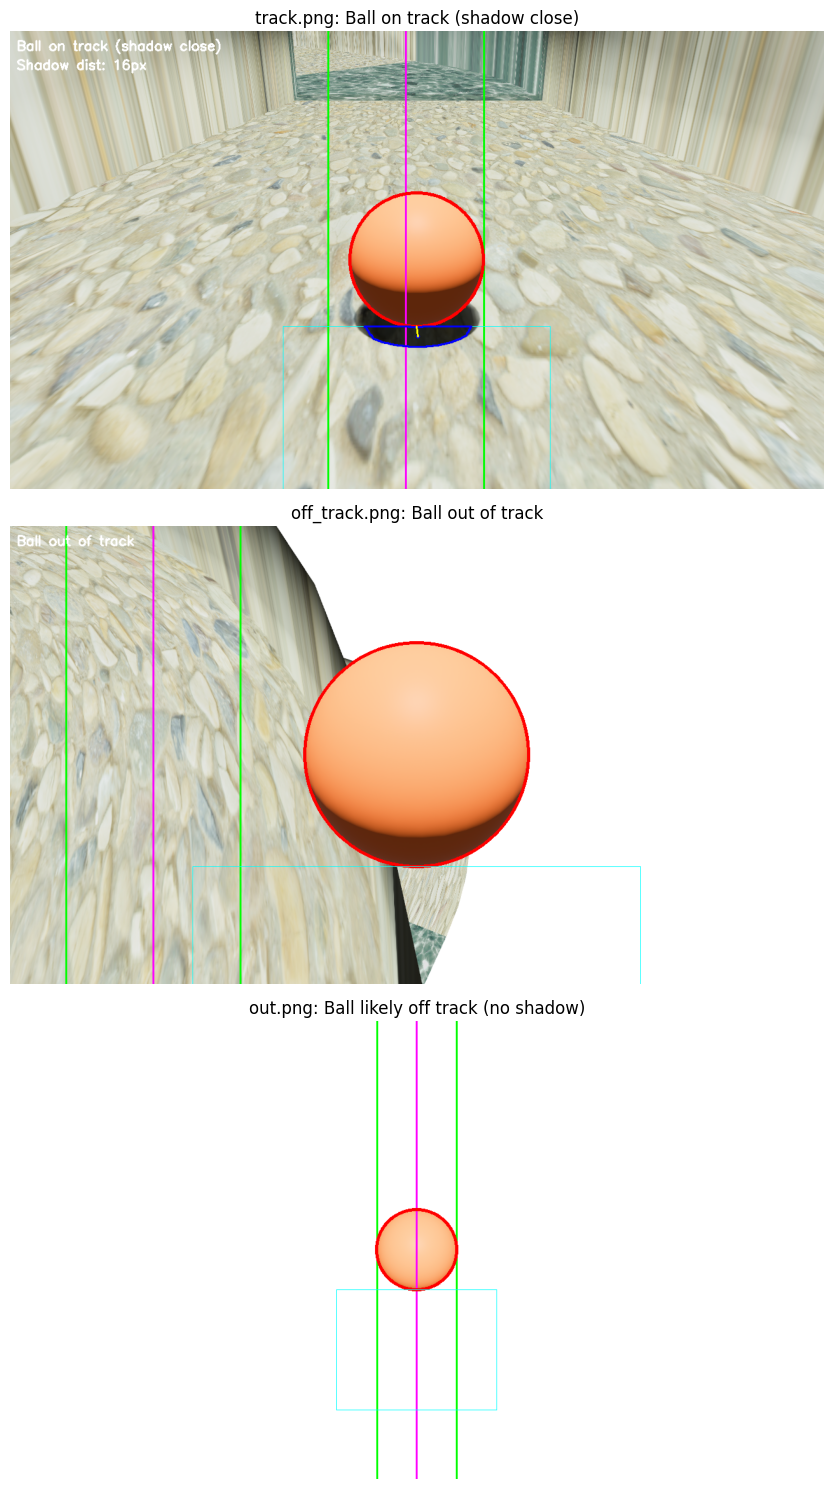

[{'ball_status': 'on_track',
  'ball_found': True,
  'ball_position': (639, 359, 105),
  'shadow_found': True,
  'shadow_distance': 16,
  'track_walls': (np.int64(500), np.int64(745)),
  'track_center': np.int64(622),
  'status': 'Ball on track (shadow close)',
  'visualization': array([[[212, 215, 204],
          [212, 215, 206],
          [212, 215, 206],
          ...,
          [175, 179, 163],
          [177, 180, 165],
          [178, 181, 168]],
  
         [[211, 215, 204],
          [212, 215, 205],
          [212, 216, 206],
          ...,
          [176, 179, 164],
          [178, 180, 166],
          [178, 181, 168]],
  
         [[211, 215, 204],
          [211, 215, 205],
          [212, 215, 205],
          ...,
          [177, 180, 164],
          [177, 180, 167],
          [179, 181, 168]],
  
         ...,
  
         [[221, 217, 195],
          [221, 217, 195],
          [221, 217, 196],
          ...,
          [196, 205, 198],
          [202, 209, 202],
          [

In [22]:
def estimate_ball_position_with_shadow(img_path,
                                       ball_hsv_low=np.array([5, 80, 80]),
                                       ball_hsv_high=np.array([25, 255, 255]),
                                       kernel_size=9,
                                       min_peak_distance=100,
                                       canny_threshold1=50,
                                       canny_threshold2=100,
                                       shadow_threshold=50):
    """
    Estimates ball position using shadow detection as an additional cue for height.
    """
    # Load the image
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    h, w = img_bgr.shape[:2]

    # Detect the ball (same as before)
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, ball_hsv_low, ball_hsv_high)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    ball_found = False
    cx_ball, cy_ball, r_ball = 0, 0, 0

    # Create visualization
    overlay = img_rgb.copy()

    # Find track walls using edge detection
    edges = cv2.Canny(gray, canny_threshold1, canny_threshold2)
    col_sum = edges.sum(axis=0)
    peaks = np.argsort(col_sum)[::-1]
    x1 = peaks[0]
    x2 = next(idx for idx in peaks if abs(idx - x1) > min_peak_distance)
    if x1 > x2:
        x1, x2 = x2, x1
    cx_track = (x1 + x2) // 2

    # Draw track walls
    cv2.line(overlay, (x1, 0), (x1, h), (0, 255, 0), 2)  # left wall
    cv2.line(overlay, (x2, 0), (x2, h), (0, 255, 0), 2)  # right wall
    cv2.line(overlay, (cx_track, 0), (cx_track, h), (255, 0, 255), 2)  # centerline

    # Variables to store classification results
    ball_status = "unknown"
    status = "Ball not found"
    shadow_distance = 0
    shadow_found = False

    if contours:
        ball_found = True
        largest = max(contours, key=cv2.contourArea)
        (cx_ball, cy_ball), r_ball = cv2.minEnclosingCircle(largest)
        cx_ball, cy_ball, r_ball = int(cx_ball), int(cy_ball), int(r_ball)

        cv2.circle(overlay, (cx_ball, cy_ball), r_ball, (255, 0, 0), 3)

        # Check if ball is between track walls
        within_walls = (x1 <= cx_ball <= x2)

        # Look for shadow below the ball
        # Define region of interest for shadow detection
        shadow_roi_top = cy_ball + r_ball  # Start from bottom of ball
        shadow_roi_bottom = min(h, shadow_roi_top + int(r_ball * 3))  # Look up to 3*radius below
        shadow_roi_left = max(0, cx_ball - int(r_ball * 2))
        shadow_roi_right = min(w, cx_ball + int(r_ball * 2))

        shadow_roi = gray[shadow_roi_top:shadow_roi_bottom,
                          shadow_roi_left:shadow_roi_right]

        if shadow_roi.size > 0:
            # Threshold to find dark areas (potential shadows)
            _, shadow_mask = cv2.threshold(shadow_roi, shadow_threshold, 255,
                                          cv2.THRESH_BINARY_INV)

            # Find contours in the shadow mask
            shadow_contours, _ = cv2.findContours(shadow_mask,
                                                 cv2.RETR_EXTERNAL,
                                                 cv2.CHAIN_APPROX_SIMPLE)

            # Draw the shadow ROI on the overlay
            cv2.rectangle(overlay,
                         (shadow_roi_left, shadow_roi_top),
                         (shadow_roi_right, shadow_roi_bottom),
                         (0, 255, 255), 1)

            if shadow_contours:
                # Find the largest dark area which is likely to be the shadow
                shadow_contour = max(shadow_contours, key=cv2.contourArea)

                if cv2.contourArea(shadow_contour) > (r_ball * r_ball * 0.2):  # Min shadow size
                    shadow_found = True
                    # Get shadow bounding box and center
                    x, y, w_s, h_s = cv2.boundingRect(shadow_contour)
                    shadow_cy = y + h_s // 2 + shadow_roi_top
                    shadow_cx = x + w_s // 2 + shadow_roi_left

                    # Draw shadow contour and center
                    cv2.drawContours(overlay, [shadow_contour], -1, (0, 0, 255), 2,
                                    offset=(shadow_roi_left, shadow_roi_top))
                    cv2.circle(overlay, (shadow_cx, shadow_cy), 3, (0, 0, 255), -1)

                    # Calculate distance between ball bottom and shadow
                    ball_bottom = cy_ball + r_ball
                    shadow_distance = shadow_cy - ball_bottom

                    # Draw a line connecting ball bottom to shadow
                    cv2.line(overlay, (cx_ball, ball_bottom),
                             (shadow_cx, shadow_cy), (255, 255, 0), 2)

                    # Add shadow distance information
                    cv2.putText(overlay, f"Shadow dist: {shadow_distance}px",
                               (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7,
                               (255, 255, 255), 2)

        # Classification with shadow information
        if not within_walls:
            status = "Ball out of track"
            ball_status = "out"
        elif shadow_found:
            if shadow_distance < r_ball * 0.5:
                status = "Ball on track (shadow close)"
                ball_status = "on_track"
            else:
                status = f"Ball above track (shadow dist: {shadow_distance}px)"
                ball_status = "off_track"
        else:
            # No shadow found - could be very high or lighting issue
            status = "Ball likely off track (no shadow)"
            ball_status = "likely_off_track"

        # Add status text
        cv2.putText(overlay, status, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                   0.7, (255, 255, 255), 2)

    return {
        'ball_status': ball_status,
        'ball_found': ball_found,
        'ball_position': (cx_ball, cy_ball, r_ball) if ball_found else None,
        'shadow_found': shadow_found,
        'shadow_distance': shadow_distance if shadow_found else None,
        'track_walls': (x1, x2),
        'track_center': cx_track,
        'status': status,
        'visualization': overlay
    }

# Function to analyze all images with shadow detection
def analyze_ball_positions_with_shadow(img_paths, **kwargs):
    fig, axes = plt.subplots(len(img_paths), 1, figsize=(12, 5 * len(img_paths)))
    if len(img_paths) == 1:
        axes = [axes]

    results = []
    for i, img_path in enumerate(img_paths):
        result = estimate_ball_position_with_shadow(img_path, **kwargs)
        axes[i].imshow(result['visualization'])
        axes[i].set_title(f"{img_path}: {result['status']}")
        axes[i].axis('off')
        results.append(result)

    plt.tight_layout()
    plt.show()
    return results

analyze_ball_positions_with_shadow(IMG_PATHS)